In [4]:
import pandas as pd

file_path = "problem_data_final.xlsx"

# ============================================
# 1) Load Data
# ============================================
reward = pd.read_excel(file_path, sheet_name="Reward")
ip = pd.read_excel(file_path, sheet_name="IP")

reward["ts"] = pd.to_datetime(reward["ts"])

print("Reward:", reward.head())
print("IP:", ip.head())

# ============================================
# 2) Merge Reward + IP (account_id 기준)
# ============================================
reward_ip = reward.merge(ip, on="account_id", how="left")

# reward_ip now contains:
# account_id | ts | reward_amount | ip

print("\nMerged reward_ip:", reward_ip.head())

# ============================================
# 3) 정렬
# ============================================
reward_ip_sorted = reward_ip.sort_values(["ip", "ts"]).copy()

# ============================================
# 4) 클러스터 탐지 함수 (시간 윈도우 기반)
# ============================================
def detect_clusters(df, window_min):
    clusters = []

    for ip_addr, group in df.groupby("ip"):
        group = group.sort_values("ts")
        events = group[["account_id", "ts", "reward_amount"]].values

        for i in range(len(events)):
            acc, ts, amt = events[i]

            # 시간 윈도우
            start = ts - pd.Timedelta(minutes=window_min)
            end = ts + pd.Timedelta(minutes=window_min)

            # 윈도우 안에 포함되는 event 찾기
            cluster = group[(group["ts"] >= start) & (group["ts"] <= end)]

            # 계정 2개 이상이면 다계정 클러스터
            if cluster["account_id"].nunique() >= 2:
                clusters.append({
                    "ip": ip_addr,
                    "center_time": ts,
                    "num_accounts": cluster["account_id"].nunique(),
                    "accounts": list(cluster["account_id"].unique()),
                    "reward_amounts": list(cluster["reward_amount"].values),
                    "events": len(cluster)
                })

    return pd.DataFrame(clusters)


# ============================================
# 5) ±5분 클러스터
# ============================================
clusters_5min = detect_clusters(reward_ip_sorted, 5)
print("\n[±5분] 다계정 클러스터 탐지")
print(clusters_5min.head())
print(f"총 {len(clusters_5min)}개 클러스터 발견")

# ============================================
# 6) ±10분 클러스터
# ============================================
clusters_10min = detect_clusters(reward_ip_sorted, 10)
print("\n[±10분] 다계정 클러스터 탐지")
print(clusters_10min.head())
print(f"총 {len(clusters_10min)}개 클러스터 발견")

# ============================================
# 7) Save to CSV
# ============================================
clusters_5min.to_csv("reward_clusters_5min.csv", index=False)
clusters_10min.to_csv("reward_clusters_10min.csv", index=False)

print("\n📁 Saved reward_clusters_5min.csv / reward_clusters_10min.csv")


Reward:      account_id                         ts  reward_amount
0  A_f96ede8d34 2025-01-02 08:14:06.194179       6.843929
1  A_f96ede8d34 2025-01-02 08:14:06.241981       6.938105
2  A_2db64f326b 2025-01-02 08:15:13.284073       6.843929
3  A_2db64f326b 2025-01-02 08:15:13.381792       6.938105
4  A_f96ede8d34 2025-01-03 07:32:10.198387       7.036313
IP:      account_id             ip
0  A_1f97e16953  100.222.49.58
1  A_946b028740    18.96.95.89
2  A_78e950c1a2   13.120.90.27
3  A_0e72128b0d  190.83.18.146
4  A_0ad0445c5a   11.179.9.226

Merged reward_ip:      account_id                         ts  reward_amount              ip
0  A_f96ede8d34 2025-01-02 08:14:06.194179       6.843929  223.196.18.104
1  A_f96ede8d34 2025-01-02 08:14:06.194179       6.843929  163.122.62.204
2  A_f96ede8d34 2025-01-02 08:14:06.194179       6.843929    49.56.71.136
3  A_f96ede8d34 2025-01-02 08:14:06.194179       6.843929   198.199.57.93
4  A_f96ede8d34 2025-01-02 08:14:06.194179       6.843929  151.20

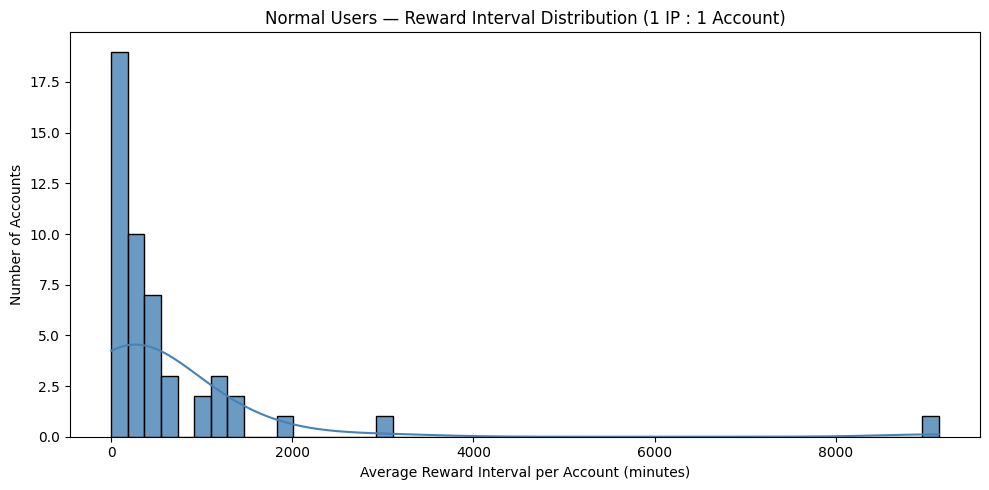

📌 정상 유저(1 IP : 1 Account) 리워드 간격 통계 (분)
평균:   617.72 분
중앙값: 237.44 분
표준편차: 1373.92 분


In [3]:
# ============================================
# 🔹 Normal User Reward Interval Distribution
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "problem_data_final.xlsx"

# 1) Load data
reward = pd.read_excel(file_path, sheet_name="Reward")
ip = pd.read_excel(file_path, sheet_name="IP")

# 2) Convert timestamp
reward["ts"] = pd.to_datetime(reward["ts"])

# 3) Merge Reward + IP
reward_ip = reward.merge(ip, on="account_id", how="left")

# 4) Count unique accounts per IP
ip_acc_count = reward_ip.groupby("ip")["account_id"].nunique().reset_index(name="unique_accounts")

# 5) Only 1-account IPs → "normal users"
single_ip_list = ip_acc_count[ip_acc_count["unique_accounts"] == 1]["ip"]

normal_reward = reward_ip[reward_ip["ip"].isin(single_ip_list)].copy()

# 6) Sort timestamps and compute interval per account
normal_reward = normal_reward.sort_values(["account_id", "ts"])
normal_reward["interval_min"] = (
    normal_reward.groupby("account_id")["ts"]
    .diff()
    .dt.total_seconds() / 60
)

# 7) Compute per-account average interval
interval_df = (
    normal_reward.groupby("account_id")["interval_min"]
    .mean()
    .dropna()
    .reset_index()
)

# 8) Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(interval_df["interval_min"], bins=50, kde=True, color="steelblue", alpha=0.8)

plt.xlabel("Average Reward Interval per Account (minutes)")
plt.ylabel("Number of Accounts")
plt.title("Normal Users — Reward Interval Distribution (1 IP : 1 Account)")

plt.tight_layout()
plt.show()

# 9) Summary stats
print("📌 정상 유저(1 IP : 1 Account) 리워드 간격 통계 (분)")
print(f"평균:   {interval_df['interval_min'].mean():.2f} 분")
print(f"중앙값: {interval_df['interval_min'].median():.2f} 분")
print(f"표준편차: {interval_df['interval_min'].std():.2f} 분")
